# Strategy Testing

The first strategy solely rely on GRU model prediction, if model predicts up => buy, if model predicts down => sell, otherwise hold.
We will calculate in-sample excellence to examine if the strategy is clearly overfitting.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
PKL_PATH = '../data/processed/usdjpy-bar-2020-01-01-2024-12-31_processed.pkl'
SEQUENCE_LENGTH=30
HORIZON=1 # The next nth timeframe to predict
STRIDE=1 # Non-overlapping timeframe
FEATURES_COLS = ['close_return']
TARGET_COLS = ['label']

In [4]:
df = pd.read_pickle(PKL_PATH)

In [5]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction,prob_down,prob_flat,prob_up,label
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,1,-0.0095,-0.000087,down,1.0,0.0,0.0,0
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,1,0.0040,0.000037,up,0.0,0.0,1.0,2
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,1,0.0020,0.000018,flat,0.0,1.0,0.0,1
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,1,0.0095,0.000087,up,0.0,0.0,1.0,2
5,2020-01-01 22:05:00,108.7700,108.7700,108.7690,108.7700,1059.999987,1,0.0050,0.000046,up,0.0,0.0,1.0,2


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['timestamp'].dt.year == 2024].copy()

In [7]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction,prob_down,prob_flat,prob_up,label
1488604,2024-01-01 22:38:00,140.9615,140.9805,140.9220,140.9755,56350.000858,6384,0.0350,0.000248,up,0.0,0.0,1.0,2
1488605,2024-01-01 22:39:00,140.9720,140.9720,140.9015,140.9015,54050.000072,6384,-0.0740,-0.000525,down,1.0,0.0,0.0,0
1488606,2024-01-01 22:40:00,140.9025,140.9025,140.9025,140.9025,6299.999833,6384,0.0010,0.000007,flat,0.0,1.0,0.0,1
1488607,2024-01-01 22:41:00,140.9040,140.9080,140.9030,140.9080,9600.000143,6384,0.0055,0.000039,up,0.0,0.0,1.0,2
1488608,2024-01-01 22:42:00,140.9090,140.9090,140.9020,140.9045,34350.000501,6384,-0.0035,-0.000025,flat,0.0,1.0,0.0,1


## In-sample exellence
We run the strategy on the same data that is used for model training.
Buy signal = +1, sell signal = -1
We multiply the signal and future return to simply analyze the performance of this strategy

In [8]:
import torch
from models.gru_model import GRUModule

In [9]:
CHECKPOINT_PATH = r'..\lightning_logs\prob_gru\version_9\checkpoints\best_checkpoint.ckpt'

In [10]:
model = GRUModule.load_from_checkpoint(CHECKPOINT_PATH)
model.to('cuda')
model.eval()

GRUModule(
  (model): GRUModel(
    (gru): GRU(1, 256, num_layers=3, batch_first=True, dropout=0.8)
    (linear): Linear(in_features=256, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
  )
  (criterion): CrossEntropyLoss()
)

In [11]:
from utils import get_sequence_start_indices
import torch
import numpy as np

In [12]:
IDs = get_sequence_start_indices(
    df,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    stride=STRIDE,
    group_col='time_group',
)

In [13]:
len(IDs)

354796

### Calculate Accumulated Excellence Curve

In [14]:
feature_df = df[FEATURES_COLS]

sequences = [feature_df.loc[i:i+SEQUENCE_LENGTH].values for i in IDs]

returns = [feature_df.loc[i+SEQUENCE_LENGTH].values for i in IDs]

sequence_arr = np.array(sequences).astype(np.float32)

batch_size = 1024
n_sequences = len(sequences)
preds = []
for i in range(0, n_sequences, batch_size):
    batch = sequence_arr[i:i+batch_size]
    batch_tensor = torch.from_numpy(batch).to('cuda')
    
    with torch.no_grad():
        _, logits = model(batch_tensor)
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(batch_preds)

return_arr = np.array(returns).squeeze()

pred_arr = np.array(preds)

signal_arr = pred_arr - 1

excellence_curve = 1 + np.cumsum(signal_arr * return_arr)



### Plotting excellence

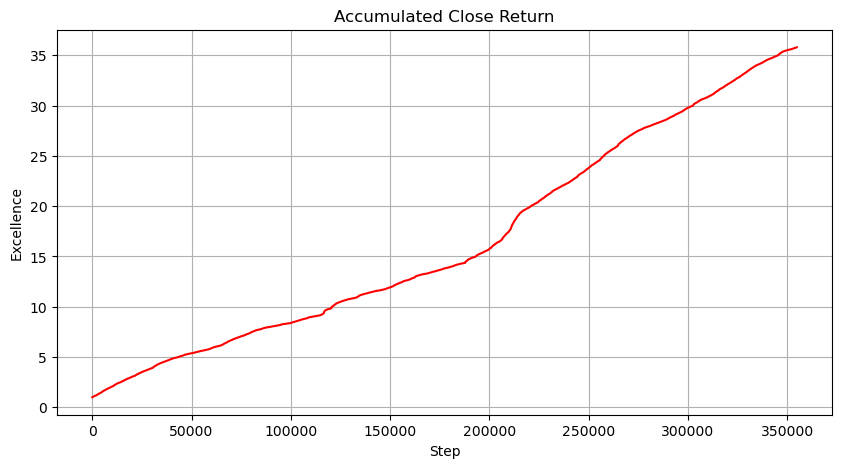

In [20]:
# Plot it
plt.figure(figsize=(10, 5))
plt.plot(excellence_curve, color='red')
plt.title("Accumulated Close Return")
plt.xlabel("Step")
plt.ylabel("Excellence")
plt.grid(True)
plt.show()

### Plotting Returns

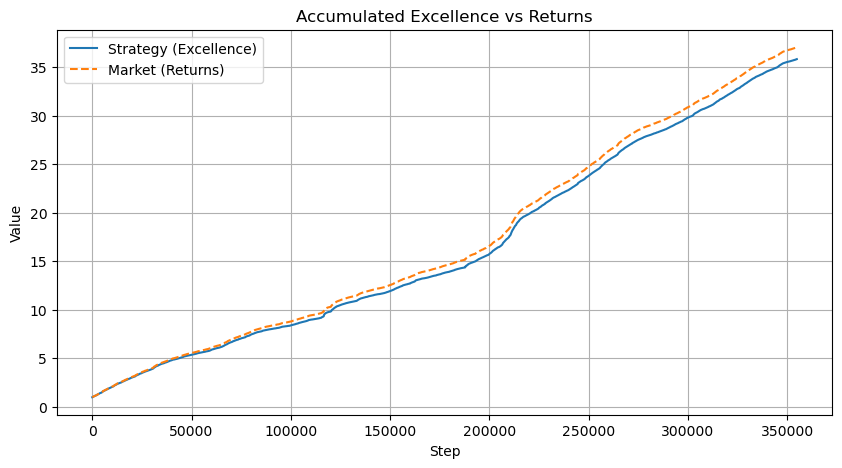

In [16]:
returns_curve = 1 + np.cumsum(np.abs(return_arr))

# Plot both
plt.figure(figsize=(10, 5))
plt.plot(excellence_curve, label="Strategy (Excellence)")
plt.plot(returns_curve, label="Market (Returns)", linestyle='--')
plt.title("Accumulated Excellence vs Returns")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

兩者幾乎完美重疊, 明顯的 overfitting